<a href="https://colab.research.google.com/github/shnhrtkyk/JTCcode/blob/main/02_%E7%89%B9%E5%BE%B4%E7%82%B9%E3%83%BB%E7%89%B9%E5%BE%B4%E9%87%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特徴点・特徴量

## ライブラリのインストール

In [ ]:
!pip install open3d==0.16

## データのダウンロード

In [ ]:
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
!tar xvfz ./bunny.tar.gz

## 特徴点

### Hariis3D

In [ ]:
import sys
import open3d as o3d
import numpy as np


# This function is only used to make the keypoints look better on the rendering
def keypoints_to_spheres(keypoints):
    spheres = o3d.geometry.TriangleMesh()
    for keypoint in keypoints.points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.005)
        sphere.translate(keypoint)
        spheres += sphere
    spheres.paint_uniform_color([1.0, 1.0, 1.0])
    return spheres


def compute_harris3d_keypoints( pcd, radius=0.01, max_nn=10, threshold=0.001 ):
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=max_nn))
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    harris = np.zeros( len(np.asarray(pcd.points)) )
    is_active = np.zeros( len(np.asarray(pcd.points)), dtype=bool )

    # Compute Harris response
    for i in range( len(np.asarray(pcd.points)) ):
        [num_nn, inds, _] = pcd_tree.search_knn_vector_3d(pcd.points[i], max_nn)
        pcd_normals = pcd.select_by_index(inds)
        pcd_normals.points = pcd_normals.normals
        [_, covar] = pcd_normals.compute_mean_and_covariance()
        harris[ i ] = np.linalg.det( covar ) / np.trace( covar )
        if (harris[ i ] > threshold):
            is_active[ i ] = True

    # ノンマキシマムサプレッション
    for i in range( len(np.asarray(pcd.points)) ):
        if is_active[ i ]:
            [num_nn, inds, _] = pcd_tree.search_knn_vector_3d(pcd.points[i], max_nn)
            inds.pop( harris[inds].argmax() )
            is_active[ inds ] = False

    keypoints = pcd.select_by_index(np.where(is_active)[0])
    return keypoints

# main
filename = "bunny/reconstruction/bun_zipper.ply"
print("Loading a point cloud from", filename)
pcd = o3d.io.read_point_cloud(filename)
print(pcd)

keypoints = compute_harris3d_keypoints( pcd )
print(keypoints)

pcd.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_plotly(
  [keypoints_to_spheres(keypoints), pcd],
  width=1200,
  height=800
)


### ISS

In [ ]:
import sys
import open3d as o3d
# This function is only used to make the keypoints look better on the rendering
def keypoints_to_spheres(keypoints):
    spheres = o3d.geometry.TriangleMesh()
    for keypoint in keypoints.points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.005)
        sphere.translate(keypoint)
        spheres += sphere
    spheres.paint_uniform_color([1.0, 1.0, 1.0])
    return spheres

filename = "bunny/reconstruction/bun_zipper.ply"
print("Loading a point cloud from", filename)
pcd = o3d.io.read_point_cloud(filename)
print(pcd)

keypoints = \
o3d.geometry.keypoint.compute_iss_keypoints(pcd,
                                            salient_radius=0.005,
                                            non_max_radius=0.005,
                                            gamma_21=0.5,
                                            gamma_32=0.5)
print(keypoints)

pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=10))
pcd.paint_uniform_color([0.5, 0.5, 0.5])
pcd.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_plotly(
  [keypoints_to_spheres(keypoints), pcd],
  width=1200,
  height=800
)

## 局所特徴量

### FPFH


In [ ]:
import sys
import open3d as o3d

filename = "bunny/reconstruction/bun_zipper.ply"
print("Loading a point cloud from", filename)
pcd = o3d.io.read_point_cloud(filename)
print(pcd)

pcd.estimate_normals(
    search_param = o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=10))

fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd,
    search_param = o3d.geometry.KDTreeSearchParamHybrid(radius=0.03, max_nn=100))

print(fpfh)
print(fpfh.data.shape)


## 大域特徴量

### 3D shape histogram

In [ ]:
def getShapeHistogram(Ps, Ns, NShells, RMax):
    hist = np.zeros(NShells)
    bins = np.square(np.linspace(0.0, RMax, NShells + 1))
    indices = np.digitize(np.sum(np.multiply(Ps, Ps), axis=0), bins) - 1
    count = np.bincount(indices)[:NShells]
    hist[:count.shape[0]] = count
    return hist


Loading a point cloud from bunny/reconstruction/bun_zipper.ply


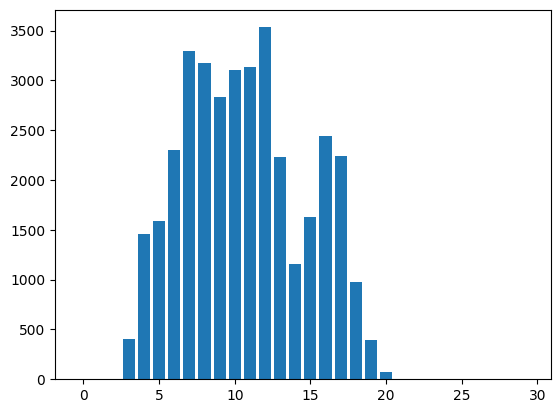

In [43]:
import matplotlib.pyplot as plt
filename = "bunny/reconstruction/bun_zipper.ply"
print("Loading a point cloud from", filename)
pcd = o3d.io.read_point_cloud(filename)
points = np.asarray(pcd.points).transpose()

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
normals = np.asarray(pcd.normals).transpose()

bins = 30 # histogramのビン数
maxr = 0.3 # 最大の半径をどれくらいにするか
hist = getShapeHistogram(points, normals, bins, maxr)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = range(30)
ax.bar(x, hist)
plt.show()